In [1]:
!mkdir '/content/input_rgb'
!cp "/content/drive/MyDrive/nct/project_folder/image_salam.tif" "/content/input_rgb"
!cp "/content/drive/MyDrive/nct/project_folder/annotation_salam.tif" "/content/input_rgb"

In [2]:
!mkdir "/content/input_rgb/all_images"
!mkdir "/content/input_rgb/all_masks"

In [3]:
!mkdir "/content/input_rgb/all_images/images"
!mkdir "/content/input_rgb/all_masks/masks"

In [4]:
from PIL import Image, ImageSequence

im = Image.open("/content/input_rgb/image_salam.tif")   #/content/salam/image.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/input_rgb/all_images/images/Page%d.png" % i)

In [5]:
from PIL import Image, ImageSequence

im = Image.open("/content/input_rgb/annotation_salam.tif")   #update_JT_11.10.22.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/input_rgb/all_masks/masks/Page%d.png" % i)

In [6]:
import numpy as np 
import pandas as pd 
from PIL import Image

import os
inputPaths = []
maskPaths = []

for dirname, _, filenames in os.walk('/content/input_rgb/all_images'):   #('/kaggle/input/fluorescent-neuronal-cells/all_images'):
    for filename in filenames:
        if filename.endswith("png"):
            fullPath = os.path.join(dirname, filename)
            inputPaths.append(fullPath)

for dirname, _, filenames in os.walk('/content/input_rgb/all_masks'):  #('/kaggle/input/fluorescent-neuronal-cells/all_masks'):
    for filename in filenames:
        if filename.endswith("png"):
            fullPath = os.path.join(dirname, filename)
            maskPaths.append(fullPath)

In [7]:
import multiprocessing as mp

 #dict
#fileInfo:(string, (imgPath:string, maskPath:string))
def LoadImgProc(fileInfo):
    filename = fileInfo[0] 
    imgPath, maskPath = fileInfo[1] 
    img = Image.open(imgPath)
    mask = Image.open(maskPath).convert('L')
    return (filename, img, mask)

def loadImages(imgPathNames, maskPathNames):
    maskFileDict = {os.path.basename(fullPath): fullPath for fullPath in maskPathNames}
    imgMaskFilePairsDict = {os.path.basename(fullPath) : (fullPath, maskFileDict[os.path.basename(fullPath)]) for fullPath in imgPathNames}
    
    #processPool = mp.Pool(processes=4,maxtasksperchild=20)
    #imgMaskPairsList = mp.Pool().map(LoadImgProc, list(imgMaskFilePairsDict.items()))
    imgMaskPairsList = [LoadImgProc(t) for t in imgMaskFilePairsDict.items()]
    #processPool.close()
    return {filename: (img, mask) for filename, img, mask in imgMaskPairsList}

imgMaskPairsRaw = loadImages(inputPaths, maskPaths)

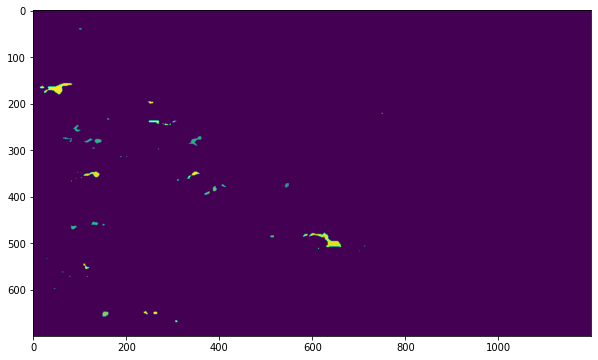

In [8]:
import matplotlib.pyplot as plt

imgListRaw = [t[0] for _, t in imgMaskPairsRaw.items()]
maskListRaw = [t[1] for _, t in imgMaskPairsRaw.items()]

#imgList = [np.array(t[0]) for _, t in imgMaskPairsRaw.items()]
#maskList = [np.array(t[1], dtype=np.uint8) for _, t in imgMaskPairsRaw.items()]

plt.figure(figsize=(10,16))
plt.imshow(maskListRaw[0])

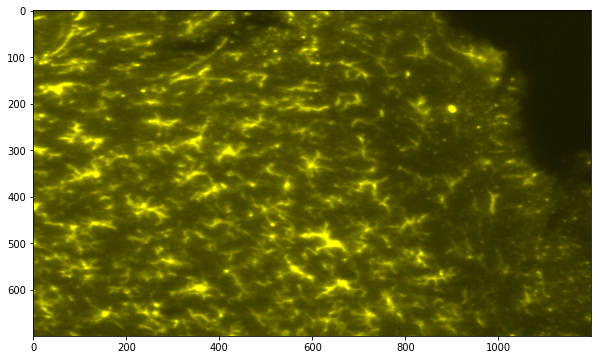

In [9]:
import matplotlib.pyplot as plt

imgListRaw = [t[0] for _, t in imgMaskPairsRaw.items()]
maskListRaw = [t[1] for _, t in imgMaskPairsRaw.items()]

#imgList = [np.array(t[0]) for _, t in imgMaskPairsRaw.items()]
#maskList = [np.array(t[1], dtype=np.uint8) for _, t in imgMaskPairsRaw.items()]

plt.figure(figsize=(10,16))
plt.imshow(imgListRaw[0])

In [10]:
from collections import namedtuple
from collections import defaultdict

CellLocation = namedtuple("CellLocation", ["nPixels", "x", "y", "width", "height"])

def bfs(r, c, nRows, nCols, traversable, groupAssignments, groupIndex):
    frontier = [(r,c)]
    groupAssignments[r][c] = groupIndex
    while len(frontier) > 0:
        curRow, curCol = frontier.pop()
        nextNodes = [
            (curRow + 1, curCol),
            (curRow - 1, curCol),
            (curRow, curCol + 1),
            (curRow, curCol - 1)
        ]
        for nextRow, nextCol in nextNodes:
            withinRange = (
                nextRow >= 0 and nextRow < nRows and
                nextCol >= 0 and nextCol < nCols)
            unvisited = (
                withinRange and 
                traversable[nextRow][nextCol] and
                groupAssignments[nextRow][nextCol] == None)
            if withinRange and unvisited:
                frontier.append((nextRow, nextCol))
                groupAssignments[nextRow][nextCol] = groupIndex
    #end of loop, all linked nodes have been marked with "groupIndex"
    return

#(imgArr:TNumeric[][]) => CellLocation[]
def markGroups(maskArr):
    threshold = int(255 * 0.5)
    #Native python list to speed up per-element indexing
    isCell = np.greater(maskArr, threshold).tolist() 
    nRows, nCols = maskArr.shape
    group = [[None]*nCols for _ in range(nRows)]
    groupIdx = 0
    #flood fill & mark cell groups
    for r in range(nRows):
        for c in range(nCols):
            unvisitedGroup = isCell[r][c] and (group[r][c] == None)
            if unvisitedGroup:
                bfs(r,c, nRows, nCols, isCell, group, groupIdx) #flood fill one cluster
                groupIdx += 1 #Ensure group clusters are unique
    
    #Get size & bounding boxes
    nGroups = groupIdx
    sizeList = [0] * nGroups
    
    rightList = [0] * nGroups
    leftList = [nCols] * nGroups

    botList = [0] * nGroups
    topList = [nRows] * nGroups
    
    for r in range(nRows):
        for c in range(nCols):
            if group[r][c] != None:
                groupNo = group[r][c]
                sizeList[groupNo] += 1
                
                rightList[groupNo] = max(rightList[groupNo], c)
                leftList[groupNo] = min(leftList[groupNo], c)
                
                botList[groupNo] = max(botList[groupNo], r)
                topList[groupNo] = min(topList[groupNo], r)
                
    #pack into tuples
    cellLocList = []
    for groupNo in range(nGroups):
        size = sizeList[groupNo]
        x = leftList[groupNo]
        y = topList[groupNo]
        width = 1 + (rightList[groupNo] - x)
        height = 1 + (botList[groupNo] - y)
        cellLocList.append(CellLocation(size, x, y, width, height))
        
    return cellLocList

In [11]:
processPool = mp.Pool()
cellLocationList = processPool.map(markGroups, [np.array(t[1], dtype=np.uint8) for _, t in imgMaskPairsRaw.items()])
processPool.close()

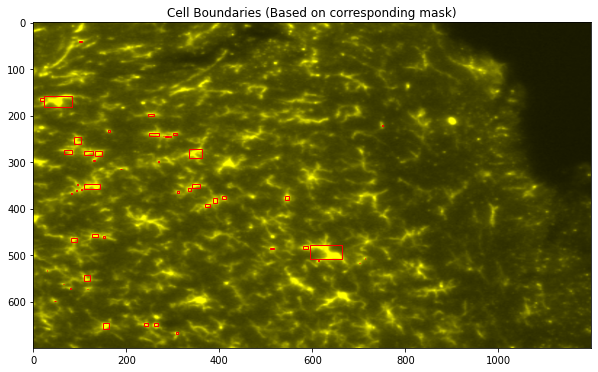

In [12]:
#Sanity check
import matplotlib.patches as patches

imageIdx = 0;

plt.figure(figsize=(10,16))

plt.title("Cell Boundaries (Based on corresponding mask)")
plt.imshow(imgListRaw[imageIdx])

ax = plt.gca();
for cellLoc in cellLocationList[imageIdx]:
    rect = patches.Rectangle((cellLoc.x, cellLoc.y), cellLoc.width, cellLoc.height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [13]:
flattenedCellLocations = []
for li in cellLocationList:
    flattenedCellLocations.extend(li)

In [14]:

nTotalCells = len(flattenedCellLocations)
print(nTotalCells)
sizes = [cellLoc.nPixels for cellLoc in flattenedCellLocations]
widths = [cellLoc.width for cellLoc in flattenedCellLocations]
heights = [cellLoc.height for cellLoc in flattenedCellLocations]

3489


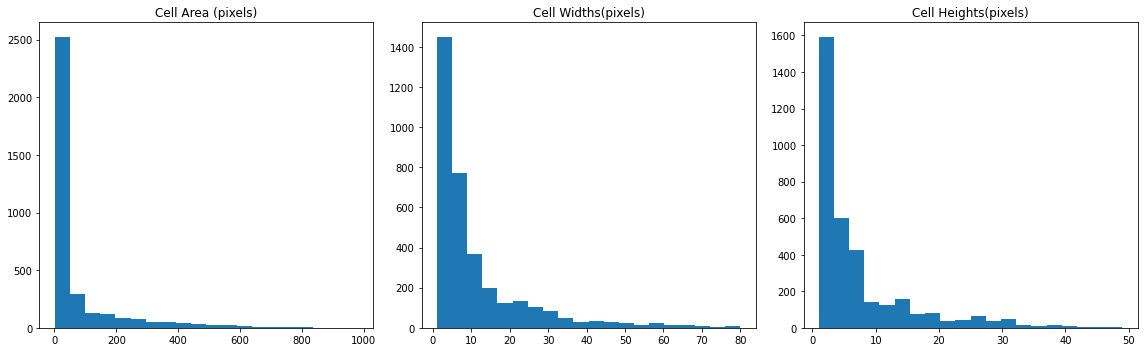

95th Percentile Values for:
 Area:389.00 pixels
 Width:41.00 pixels
 Height:26.00 pixels


In [15]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

nBins = 20
ax[0].hist(sizes,bins=nBins)
ax[0].set_title('Cell Area (pixels)')

ax[1].hist(widths,bins=nBins)
ax[1].set_title('Cell Widths(pixels)')

ax[2].hist(heights,bins=nBins)
ax[2].set_title('Cell Heights(pixels)')

plt.tight_layout()
plt.show()

percentile = 95

sizePercentile = np.percentile(sizes, percentile)
widthPercentile = np.percentile(widths, percentile)
heightPercentile = np.percentile(heights, percentile)

print("{0}th Percentile Values for:".format(percentile))
print(" Area:{:0.2f} pixels".format(sizePercentile))
print(" Width:{:0.2f} pixels".format(widthPercentile))
print(" Height:{:0.2f} pixels".format(heightPercentile))

In [16]:
totalNoOfMarkedPixels = sum(sizes)
overallNoOfPixels = sum((mask.size[0] * mask.size[1] for mask in maskListRaw))
totalNoOfUnmarkedPixels = overallNoOfPixels - totalNoOfMarkedPixels

markedInv = overallNoOfPixels / totalNoOfMarkedPixels
unmarkedInv = overallNoOfPixels / totalNoOfUnmarkedPixels
normalizationCoeff = 1 / (markedInv + unmarkedInv)
classWeights = {
    0: unmarkedInv * normalizationCoeff, #unmarked pixels
    1: markedInv * normalizationCoeff    #marked as cells
}

print("Percentage of pixels which are neural cells: {0}%".format((totalNoOfMarkedPixels/ overallNoOfPixels) * 100))
print(classWeights)

Percentage of pixels which are neural cells: 0.37982440476190477%
{0: 0.0037982440476190473, 1: 0.9962017559523809}


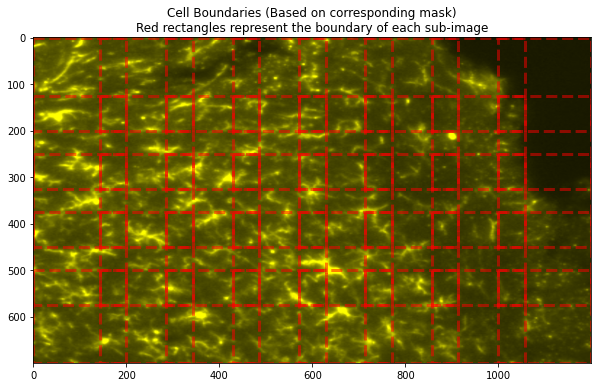

In [20]:
import math

Rect = namedtuple("Rect", ["x", "y", "width" , "height"])

def EvenlySpacedPartitions(width, height, partitionLength, minOverlap):
    def minPartitions(dimLength):
        return math.ceil((dimLength - minOverlap) / (partitionLength - minOverlap))
    nRows = minPartitions(height)
    nCols = minPartitions(width)
    
    def getPartitionStartingPositions(dimLength, nPartitions):
        overlap = (dimLength - nPartitions * partitionLength) / (1- nPartitions)
        advance = partitionLength - overlap
        return [advance * i for i in range(nPartitions)]
    
    rowPositions = getPartitionStartingPositions(height, nRows)
    colPositions = getPartitionStartingPositions(width, nCols)
    partitions = []
    for colStart in colPositions: #x
        for rowStart in rowPositions: #y
            partitions.append(Rect(colStart, rowStart, partitionLength, partitionLength))
    return partitions

imageIdx = 0;

plt.figure(figsize=(10,16))

plt.title("Cell Boundaries (Based on corresponding mask)\nRed rectangles represent the boundary of each sub-image")
plt.imshow(imgListRaw[imageIdx])

width, height  = imgListRaw[imageIdx].size

partitions = EvenlySpacedPartitions(width, height, 200, 50)

ax = plt.gca();
for partition in partitions:
    rect = patches.Rectangle((partition.x, partition.y), partition.width, partition.height, linewidth=3, edgecolor='r', alpha= 0.5, linestyle="--", facecolor='none')
    ax.add_patch(rect)

plt.show()

In [21]:
CroppedImage = namedtuple("CroppedImage", ["image", "mask", "sourceRect"])

def CropImage(pilImage, pilMask, partitions):
    croppedImages = []
    for partition in partitions:
        top, bot = (partition.y, partition.y + partition.height)
        left, right = (partition.x, partition.x + partition.width)
        croppedImg = pilImage.crop((left, top, right, bot))
        croppedMask = pilMask.crop((left, top, right, bot))
        croppedImages.append(CroppedImage(croppedImg, croppedMask, partition))
    return croppedImages

def GetAllPartitions(pilImageList, partitionSize, minOverlap):
    partitionList = []
    for img in pilImageList:
        width, height = img.size
        partitions = EvenlySpacedPartitions(width, height, partitionSize, minOverlap)
        partitionList.append(partitions)
    return partitionList

partitionList = GetAllPartitions(imgListRaw, 400, 100)

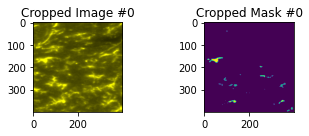

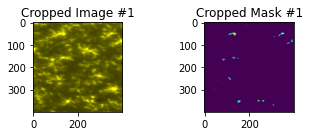

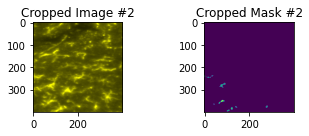

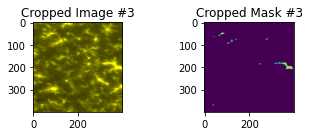

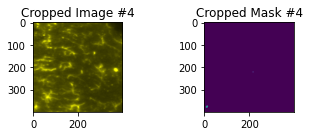

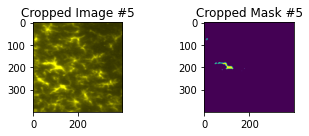

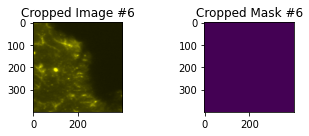

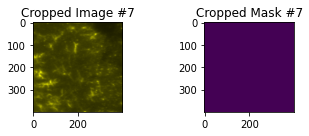

In [23]:
sampleCrop = CropImage(imgListRaw[0], maskListRaw[0], partitionList[0])

for idx, croppedImagePair in enumerate(sampleCrop):
    fig, ax = plt.subplots(1, 2, figsize=(5,2))

    ax[0].imshow(croppedImagePair.image)
    ax[0].set_title('Cropped Image #{0}'.format(idx))
    
    ax[1].imshow(croppedImagePair.mask)
    ax[1].set_title('Cropped Mask #{0}'.format(idx))
    
    plt.tight_layout()
    plt.show()

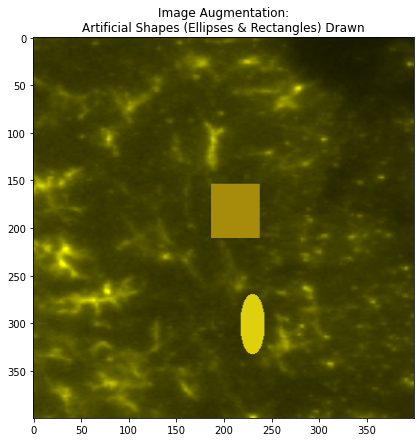

In [24]:
from PIL import ImageDraw
from enum import Enum
import random

TColour = namedtuple("TColour", ["r", "g", "b"])

#Sampled from the cells in the first image
darkYellow = TColour(101, 61, 6)
brightYellow = TColour(247, 237, 15)

#linear lerp between the rgb values
#frac = fraction of colour 2
def lerpColours(colour1, colour2, frac):
    r = colour1.r * (1 - frac) + colour2.r * frac
    g = colour1.g * (1 - frac) + colour2.g * frac
    b = colour1.b * (1 - frac) + colour2.b * frac
    return TColour(int(r),int(g),int(b))

class ENShape(Enum):
    Ellipse = 0
    Rect = 1

def DrawRandomEllipse(img, shape = ENShape.Ellipse):
    imgWidth, imgHeight = img.size
    centreX, centreY = (random.uniform(0, imgWidth), random.uniform(0, imgHeight))
    shapeWidth, shapeHeight = (random.uniform(25, 75), random.uniform(25, 75)) #based on the cell size distribution
    boundingBox = (
        int(centreX - shapeWidth * 0.5),
        int(centreY - shapeHeight * 0.5),
        int(centreX + shapeWidth * 0.5), 
        int(centreY + shapeHeight * 0.5)
    )
    
    fillColour = lerpColours(darkYellow, brightYellow, random.uniform(0, 1))
    
    gc = ImageDraw.Draw(img)
    if shape == ENShape.Ellipse:
        gc.ellipse(boundingBox, fill=fillColour, outline=None, width=1)
    elif shape == ENShape.Rect:
        rad = int(random.uniform(1, min(shapeWidth, shapeHeight) * 0.3))
        gc.rectangle(boundingBox, fill=fillColour, outline=None, width=1)

sampleImage = sampleCrop[-1].image.copy()
DrawRandomEllipse(sampleImage, ENShape.Ellipse)
DrawRandomEllipse(sampleImage, ENShape.Rect)

plt.figure(figsize=(7,7))
plt.title("Image Augmentation:\nArtificial Shapes (Ellipses & Rectangles) Drawn")
plt.imshow(sampleImage)

In [25]:
#Affine transformations
def TranslateXForm(x,y):
    return np.array(
        [[1,0,x],
         [0,1,y],
         [0,0,1]]
    );
        
def RotateXForm(deg):
    rad = math.radians(deg)
    return np.array(
        [[math.cos(rad),-math.sin(rad),0],
         [math.sin(rad), math.cos(rad),0],
         [0,0,1]]
    );

def ShearXForm(cx, cy):
    return np.array(
        [[1,cx,0],
         [cy,1,0],
         [0,0,1]]
    );

def ScaleXForm(xScale, yScale):
    return np.array(
        [[xScale,0,0],
         [0,yScale,0],
         [0,0,1]]
    );

def GetRandomImageXForm(imgWidth, imgHeight):
    xform = np.identity(3)
    xform = np.matmul(TranslateXForm(imgWidth * -0.5, imgHeight * -0.5), xform) # Set image centre as origin
    #Now go bananas
    #shear
    xform = np.matmul(ShearXForm(random.uniform(0, 0.20), random.uniform(0, 0.20)), xform)
    #rotation
    xform = np.matmul(RotateXForm(random.uniform(0, 360)), xform)
    #scaling
    xform = np.matmul(xform, ScaleXForm(random.uniform(0.8, 1.5), random.uniform(0.8, 1.5)))
    #horizontal/vertical flips
    yFlipCoeff = 1 if bool(random.getrandbits(1)) else -1
    xFlipCoeff = 1 if bool(random.getrandbits(1)) else -1
    xform = np.matmul(ScaleXForm(xFlipCoeff, yFlipCoeff), xform)
    
    xform = np.matmul(TranslateXForm(imgWidth * 0.5, imgHeight * 0.5), xform) #Shift back to 0,0 as top left origin
    return xform

imgBgColour1 = TColour(20, 8, 0)
imgBgColour2 = TColour(49, 25, 1)

def ApplyAffineXForm(image, xform, bgColour):
    invXForm = np.linalg.inv(xform) #required by PIL
    unpackedXForm = (*invXForm[0],*invXForm[1])
    
    xformedImg = image.transform(
        image.size, 
        Image.AFFINE, 
        data=unpackedXForm, 
        resample=Image.BILINEAR,
        fillcolor=bgColour)
    return xformedImg


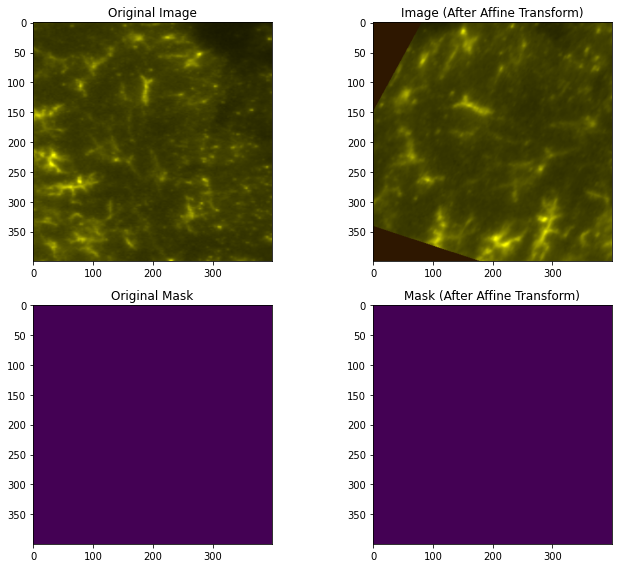

In [26]:
sampleImage = sampleCrop[-1].image
sampleMask = sampleCrop[-1].mask

augmentingXForm = GetRandomImageXForm(*sampleImage.size)
bgColour = lerpColours(imgBgColour1, imgBgColour2, random.uniform(0, 1))

xformedImg = ApplyAffineXForm(sampleImage,augmentingXForm, bgColour)
xformedMask = ApplyAffineXForm(sampleMask,augmentingXForm, 0)

fig, ax = plt.subplots(2, 2, figsize=(10,8))

ax[0,0].imshow(sampleImage)
ax[0,0].set_title('Original Image')

ax[0,1].imshow(xformedImg)
ax[0,1].set_title('Image (After Affine Transform)')

ax[1,0].imshow(sampleMask)
ax[1,0].set_title('Original Mask')

ax[1,1].imshow(xformedMask)
ax[1,1].set_title('Mask (After Affine Transform)')

plt.tight_layout()
plt.show()

In [27]:
partitionedImagesSet = [CropImage(img, mask, partitionInfo) for img, mask, partitionInfo in zip(imgListRaw, maskListRaw, partitionList)]

In [28]:
flattenedImages = []
flattenedMasks = []
for imageMaskPairList in partitionedImagesSet:
    for imageMaskPair in imageMaskPairList:
        flattenedImages.append(imageMaskPair.image)
        flattenedMasks.append(imageMaskPair.mask)

In [29]:
print(len(flattenedImages))

640


In [30]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import apply_affine_transform

subImgSize = 400
finalMaskSize = 50


#Note: Will draw directly on the image, pass a copy if the intent isn't to alter the original
def drawRandomShape(pilImage):
    nEllipses = random.randint(0, 2)
    for _ in range(nEllipses):
        DrawRandomEllipse(pilImage, ENShape.Ellipse)
    nRects = random.randint(0, 2)        
    for _ in range(nRects):
        DrawRandomEllipse(pilImage, ENShape.Rect)
    return pilImage

class ImageSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, mask_final_dim): 
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffleIndices()
        self.mask_dim = (mask_final_dim, mask_final_dim) #Used to downscale the mask
        self.bDrawShapes = False
        self.bAffineTransform = False
    
    def shuffleIndices(self):
        nSamples = len(self.x)
        indices = np.arange(nSamples)
        np.random.shuffle(indices)
        self.indices = indices
    
    def on_epoch_end(self):
        self.shuffleIndices()
        
    def enableFeatures(self, bDrawShapes, bAffineTransform):
        self.bDrawShapes = bDrawShapes
        self.bAffineTransform = bAffineTransform
        
    def __len__(self):
        return math.floor(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        startingIdx = idx * self.batch_size
        endingIdx = (idx + 1) * self.batch_size
        selectedIndices = self.indices[startingIdx:endingIdx]
        
        splitImages = [self.x[idx] for idx in selectedIndices]
        splitMasks = [self.y[idx] for idx in selectedIndices]
        
        imgWithRandomShapes = [drawRandomShape(img.copy()) if self.bDrawShapes else img 
                                   for img in splitImages]
        masksDownscaled = [tMask.resize(self.mask_dim, Image.NEAREST ) for tMask in splitMasks]
        
        x_np = [np.array(img) for img in imgWithRandomShapes]
        y_np = [np.array(img) for img in masksDownscaled]
        
        x_augmented = []
        y_augmented = []
        
        for x, y in zip(x_np, y_np):
            rotation = random.uniform(0, 360)
            shear = random.uniform(-10, 10)
            yFlipCoeff = 1 if bool(random.getrandbits(1)) else -1
            xFlipCoeff = 1 if bool(random.getrandbits(1)) else -1
            xScale = random.uniform(0.8, 1.5) * xFlipCoeff
            yScale = random.uniform(0.8, 1.5) * yFlipCoeff
            
            bgColor = random.uniform(0,50) #can't specify separate values for RGB
            #x_aug = apply_affine_transform(x, theta=rotation, shear=shear, zx=xScale, zy=yScale, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=bgColor, order=1)
            x_aug = None
            if self.bAffineTransform:
                x_aug = apply_affine_transform(x, theta=rotation, shear=shear, zx=xScale, zy=yScale, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=bgColor, order=1)
            else:
                x_aug = x
                
            original_y_shape = y.shape
            y_reshaped = np.reshape(y, (*original_y_shape, 1))
            y_aug = None
            if self.bAffineTransform:
                y_aug = apply_affine_transform(y_reshaped, theta=rotation, shear=shear, zx=xScale, zy=yScale, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0, order=1)
            else:
                y_aug = y_reshaped
                
            y_aug_reshaped = np.reshape(y_aug, original_y_shape)
            x_augmented.append(x_aug)
            y_augmented.append(y_aug_reshaped)
            
        return (np.array(x_augmented), np.array(y_augmented) / 255)

In [31]:
from sklearn.model_selection import train_test_split

img_train, img_test, mask_train, mask_test = train_test_split(flattenedImages, flattenedMasks , test_size=0.2, random_state=0xDEADBEEF)

print(len(img_train), len(img_test))

512 128


In [32]:
#Filter out those within the training set that actually have cells

trainSetWithCells = [(img, mask) for img, mask in 
                     zip(img_train, mask_train) 
                     if (np.sum(np.array(mask)) > 255 * 5)]
img_train_with_cells, mask_train_with_cells = zip(*trainSetWithCells) 

#for weight calculation
nUnmarkedPixels = sum([np.sum(np.array(mask) < 122) for mask in mask_train_with_cells])
nMarkedPixels = sum([np.sum(np.array(mask) > 122) for mask in mask_train_with_cells])

totalPixels = nMarkedPixels + nUnmarkedPixels
invMarked = totalPixels / nMarkedPixels
invUnmarked = totalPixels / nUnmarkedPixels
normalizingCoeff = 1 / (invMarked + invUnmarked)

lossWeights = [invUnmarked * normalizingCoeff, invMarked  * normalizingCoeff]

print(len(img_train_with_cells))
print("Unmarked: {0}, marked {1}".format(nUnmarkedPixels, nMarkedPixels))
print("Percentage of pixels which are neural cells (filtered training set): {0}%".format((nMarkedPixels/ totalPixels) * 100))
print(lossWeights)

388
Unmarked: 61750286, marked 329533
Percentage of pixels which are neural cells (filtered training set): 0.5308214574530251%
[0.005308214574530252, 0.9946917854254699]


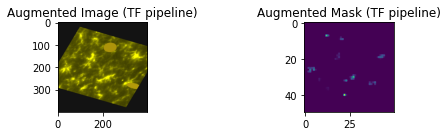

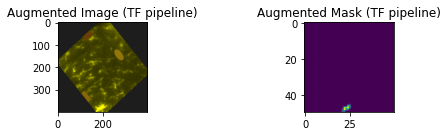

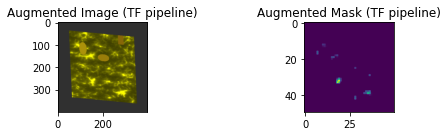

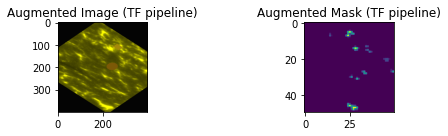

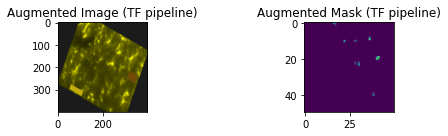

In [33]:
batch_size = 5
generator = ImageSequence(img_train_with_cells, mask_train_with_cells, batch_size, finalMaskSize)
generator.enableFeatures(True, True)
images, masks = generator.__getitem__(0)

for img, mask in zip(images, masks):
    fig, ax = plt.subplots(1, 2, figsize=(7,2))

    ax[0].imshow(img)
    ax[0].set_title('Augmented Image (TF pipeline)')
    
    ax[1].imshow(mask)
    ax[1].set_title('Augmented Mask (TF pipeline)')
    
    plt.tight_layout()
    plt.show()

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

keras.backend.clear_session()

#Loss function shamelessly copied from Sayan Dey from https://stackoverflow.com/questions/46009619/keras-weighted-binary-crossentropy
def weighted_binary_crossentropy(zero_weight, one_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        b_ce = keras.backend.binary_crossentropy(y_true, y_pred)
        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return keras.backend.mean(weighted_b_ce)

    return weighted_binary_crossentropy

model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(subImgSize, subImgSize, 3)),
        
        layers.Lambda(lambda x : x / 255), #{0-255} to {0-1}
        layers.Conv2D(196, 5, strides=(2,2), activation='relu'),
        layers.MaxPooling2D(2),
                
        layers.Conv2D(256, 5,  activation='relu'),
        layers.MaxPooling2D(2),
        
        layers.Conv2D(512, 3, activation='relu'),   
        layers.Conv2D(512, 1, activation='relu'),
        #layers.Conv2D(512, 2, activation='relu'),
        #layers.MaxPooling2D(2),
        
        layers.Conv2DTranspose(1,finalMaskSize - 44,activation="sigmoid")
    ]
)

opt = keras.optimizers.Adam(learning_rate=0.0001)
#reduce weight of +ve class to reduce over-eagerness to evaluate all yellow blobs are cells
model.compile(optimizer=opt, loss = weighted_binary_crossentropy(lossWeights[0], lossWeights[1] * 0.33), metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 196)     14896     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 196)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 256)       1254656   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 512)       1

In [50]:
#With the filtered dataset
batch_size = 16
generator = ImageSequence(img_train_with_cells, mask_train_with_cells, batch_size, finalMaskSize)

history = model.fit(
    x=generator,
    epochs=50)
    #todo validation_data=(testDataNp, testLabels))

Epoch 1/50
24/24 [==============================] - 4s 149ms/step - loss: 0.0010 - acc: 0.9857
Epoch 2/50
24/24 [==============================] - 4s 148ms/step - loss: 9.5997e-04 - acc: 0.9862
Epoch 3/50
24/24 [==============================] - 4s 150ms/step - loss: 9.2918e-04 - acc: 0.9862
Epoch 4/50
24/24 [==============================] - 4s 149ms/step - loss: 9.2680e-04 - acc: 0.9862
Epoch 5/50
24/24 [==============================] - 4s 149ms/step - loss: 9.1008e-04 - acc: 0.9863
Epoch 6/50
24/24 [==============================] - 4s 149ms/step - loss: 8.8645e-04 - acc: 0.9868
Epoch 7/50
24/24 [==============================] - 4s 149ms/step - loss: 9.3313e-04 - acc: 0.9859
Epoch 8/50
24/24 [==============================] - 4s 150ms/step - loss: 8.8971e-04 - acc: 0.9867
Epoch 9/50
24/24 [==============================] - 4s 150ms/step - loss: 8.9244e-04 - acc: 0.9866
Epoch 10/50
24/24 [==============================] - 4s 151ms/step - loss: 8.9012e-04 - acc: 0.9866
Epoch 11/50
2

1/1 [==============================] - 0s 18ms/step


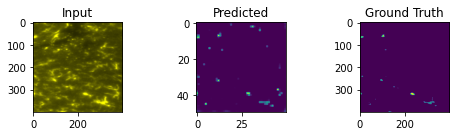

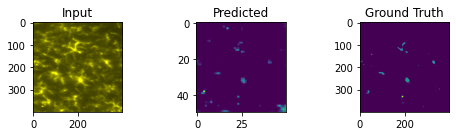

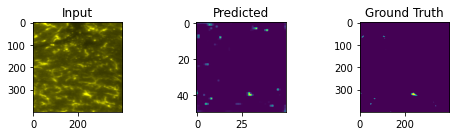

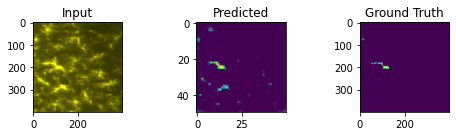

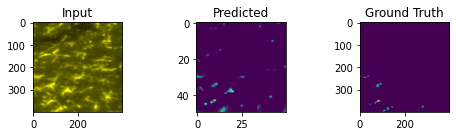

In [51]:
#Not from the validation set, just used for illustration
def previewResults():
    testCases = np.array([np.array(img) for img in img_train_with_cells[:5]])
    testGroundTruth = mask_train_with_cells[:5]
    predictions = model.predict(testCases)

    for img, pred, actual in zip(testCases, predictions, testGroundTruth):
        fig, ax = plt.subplots(1, 3, figsize=(7,2))

        ax[0].imshow(img)
        ax[0].set_title('Input')
    
        ax[1].imshow(np.squeeze(pred))
        ax[1].set_title('Predicted')

        ax[2].imshow(actual)
        ax[2].set_title('Ground Truth')

        plt.tight_layout()
        plt.show()

previewResults()

In [52]:
generator.enableFeatures(True, False) #Enable Random shapes

history = model.fit(
    x=generator,
    epochs=50)

Epoch 1/50
24/24 [==============================] - 4s 153ms/step - loss: 9.4355e-04 - acc: 0.9864
Epoch 2/50
24/24 [==============================] - 4s 153ms/step - loss: 8.8629e-04 - acc: 0.9870
Epoch 3/50
24/24 [==============================] - 4s 154ms/step - loss: 9.4409e-04 - acc: 0.9856
Epoch 4/50
24/24 [==============================] - 4s 155ms/step - loss: 9.6133e-04 - acc: 0.9851
Epoch 5/50
24/24 [==============================] - 4s 155ms/step - loss: 9.1651e-04 - acc: 0.9864
Epoch 6/50
24/24 [==============================] - 4s 156ms/step - loss: 8.8762e-04 - acc: 0.9867
Epoch 7/50
24/24 [==============================] - 4s 157ms/step - loss: 8.7847e-04 - acc: 0.9864
Epoch 8/50
24/24 [==============================] - 4s 158ms/step - loss: 8.5504e-04 - acc: 0.9873
Epoch 9/50
24/24 [==============================] - 4s 157ms/step - loss: 8.8219e-04 - acc: 0.9864
Epoch 10/50
24/24 [==============================] - 4s 158ms/step - loss: 8.6006e-04 - acc: 0.9874
Epoch 11/

1/1 [==============================] - 0s 17ms/step


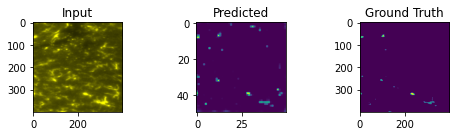

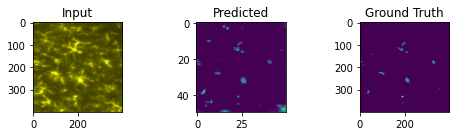

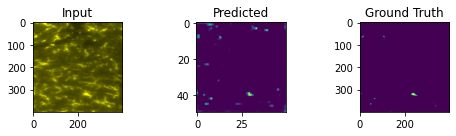

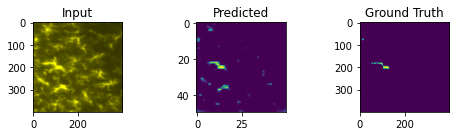

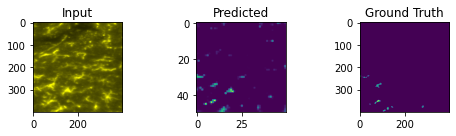

In [53]:
previewResults()

In [54]:
generator = ImageSequence(img_train, mask_train, batch_size, finalMaskSize)
generator.enableFeatures(True, True)

history = model.fit(
    x=generator,
    epochs=40)

Epoch 1/40
32/32 [==============================] - 14s 435ms/step - loss: 7.2493e-04 - acc: 0.9867
Epoch 2/40
32/32 [==============================] - 14s 434ms/step - loss: 6.6069e-04 - acc: 0.9879
Epoch 3/40
32/32 [==============================] - 14s 435ms/step - loss: 6.7087e-04 - acc: 0.9879
Epoch 4/40
32/32 [==============================] - 14s 434ms/step - loss: 6.3871e-04 - acc: 0.9882
Epoch 5/40
32/32 [==============================] - 14s 439ms/step - loss: 6.6589e-04 - acc: 0.9878
Epoch 6/40
32/32 [==============================] - 14s 437ms/step - loss: 6.4962e-04 - acc: 0.9884
Epoch 7/40
32/32 [==============================] - 14s 437ms/step - loss: 6.3991e-04 - acc: 0.9883
Epoch 8/40
32/32 [==============================] - 14s 435ms/step - loss: 6.5214e-04 - acc: 0.9883
Epoch 9/40
32/32 [==============================] - 14s 432ms/step - loss: 6.5972e-04 - acc: 0.9880
Epoch 10/40
32/32 [==============================] - 14s 444ms/step - loss: 6.5254e-04 - acc: 0.9881

1/1 [==============================] - 0s 16ms/step


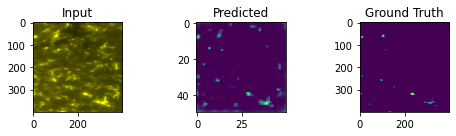

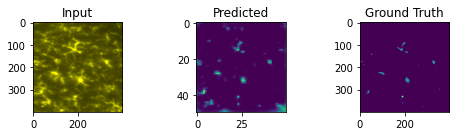

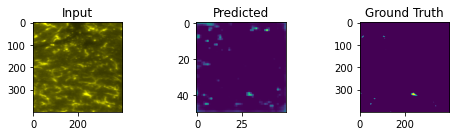

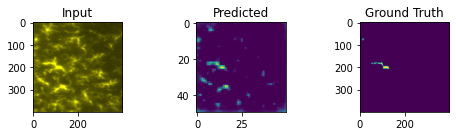

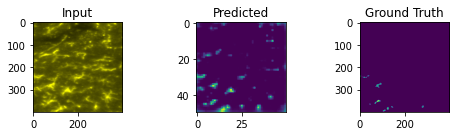

In [55]:
previewResults()

In [56]:
#img_test, mask_test
predictions = model.predict(np.array([np.array(img) for img in img_test]))

4/4 [==============================] - 0s 133ms/step


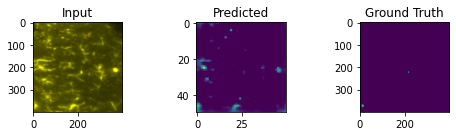

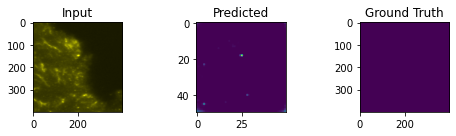

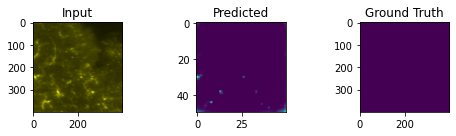

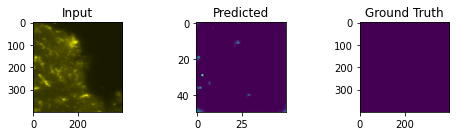

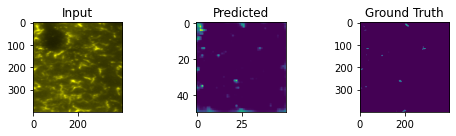

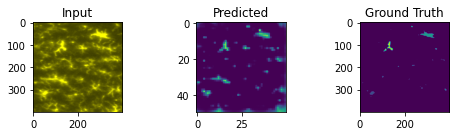

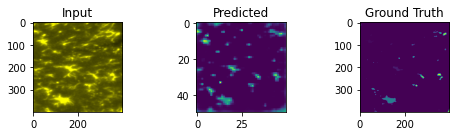

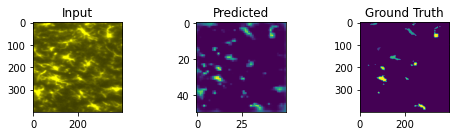

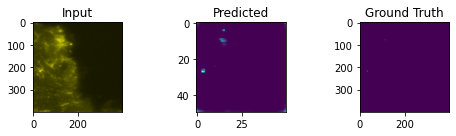

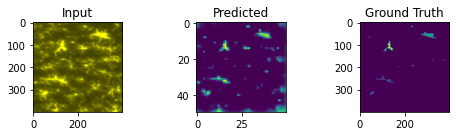

In [57]:
import itertools

for img, pred, actual in itertools.islice(zip(img_test, predictions, mask_test), 10):
    fig, ax = plt.subplots(1, 3, figsize=(7,2))
    ax[0].imshow(img)
    ax[0].set_title('Input')

    ax[1].imshow(np.squeeze(pred))
    ax[1].set_title('Predicted')
    ax[2].imshow(actual)
    ax[2].set_title('Ground Truth')
    plt.tight_layout()
    plt.show()

In [58]:
def computeMetrics(pred, groundTruthImages):
    actualList = []
    predList = []
    for p, groundTruth in zip(pred, groundTruthImages):
        resized = groundTruth.resize((finalMaskSize,finalMaskSize), Image.BILINEAR)
        resizedThreshold = np.array(resized, dtype=np.uint8) > 122 #0-255
        predThreshold = (p > 0.5).astype(np.uint8) #0-1
        actualList.append(np.reshape(resizedThreshold, -1))
        predList.append(np.reshape(predThreshold, -1))
    actual = np.concatenate((actualList), axis=0)
    predictions = np.concatenate((predList), axis=0)
    return (predictions, actual)

pred1D, actual1D = computeMetrics(predictions, mask_test)

              precision    recall  f1-score   support

   Non-Cells       1.00      1.00      1.00    319484
       Cells       0.32      0.81      0.46       516

    accuracy                           1.00    320000
   macro avg       0.66      0.91      0.73    320000
weighted avg       1.00      1.00      1.00    320000



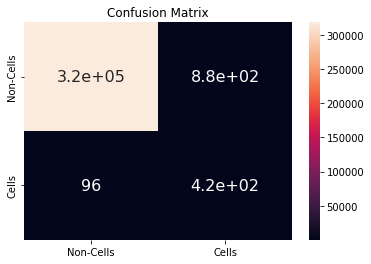

In [59]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn

labels= ["Non-Cells", "Cells"]
print(classification_report(actual1D, pred1D, target_names=labels))
confusionMatrix = confusion_matrix(actual1D, pred1D)

df_cm = pd.DataFrame(confusionMatrix, index=labels, columns=labels)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}).set_title("Confusion Matrix") # font size
plt.show()

In [60]:
#Apply to an entire image
#pilImage => np.array
def applyModelToImage(pilImage, overlap=100):
    width, height = pilImage.size
    partitions = EvenlySpacedPartitions(width, height, 400, overlap)
    subImages = []#np arrays
    for partition in partitions:
        top, bot = (partition.y, partition.y + partition.height)
        left, right = (partition.x, partition.x + partition.width)
        croppedImg = pilImage.crop((left, top, right, bot))
        subImages.append(np.array(croppedImg))
    
    predictions = model.predict(np.array(subImages))
    predictionsUpscaled = []
    for pred in predictions:
        img = Image.fromarray(np.uint8(pred.reshape((50,50)) * 255))
        upscaled = np.array(img.resize((400,400)), dtype=np.uint8)
        predictionsUpscaled.append(upscaled)
    
    #Combine predictions into a single image
    #Use a "minimum" blending function, i.e. be as conservative as positive for cell predictions
    output = np.full((height, width), 255, dtype=np.uint8)
    for pred, location in zip(predictionsUpscaled, partitions):
        imgTop, imgBot = (round(location.y), round(location.y + location.height))
        imgLeft, imgRight = (round(location.x), round(location.x + location.width))
        output[imgTop:imgBot,imgLeft:imgRight] = np.minimum(output[imgTop:imgBot,imgLeft:imgRight], pred)
    
    return output

1/1 [==============================] - 0s 20ms/step


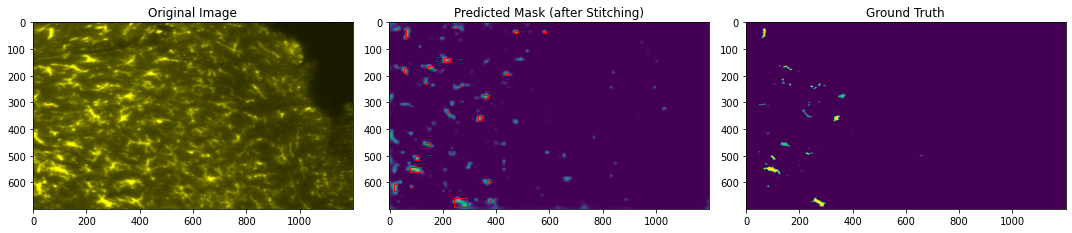

Number of cells (Intensity threshold=122): 25
 1) CellLocation(nPixels=4, x=251, y=19, width=3, height=2)
 2) CellLocation(nPixels=29, x=27, y=24, width=9, height=5)
 3) CellLocation(nPixels=202, x=63, y=26, width=10, height=30)
 4) CellLocation(nPixels=97, x=468, y=32, width=15, height=8)
 5) CellLocation(nPixels=44, x=580, y=32, width=7, height=8)
 6) CellLocation(nPixels=17, x=59, y=56, width=4, height=5)
 7) CellLocation(nPixels=172, x=206, y=134, width=19, height=14)
 8) CellLocation(nPixels=135, x=145, y=162, width=19, height=13)
 9) CellLocation(nPixels=135, x=53, y=171, width=12, height=18)
 10) CellLocation(nPixels=28, x=438, y=191, width=8, height=5)
 11) CellLocation(nPixels=23, x=137, y=224, width=5, height=6)
 12) CellLocation(nPixels=8, x=273, y=234, width=3, height=4)
 13) CellLocation(nPixels=131, x=351, y=272, width=18, height=10)
 14) CellLocation(nPixels=10, x=216, y=332, width=4, height=5)
 15) CellLocation(nPixels=144, x=332, y=353, width=14, height=15)
 16) CellLo

In [61]:
idx = 25
stitchedMask = applyModelToImage(imgListRaw[idx], 100)

predictedCellLocations = markGroups(stitchedMask) #threshold = 122

fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].imshow(imgListRaw[idx])
ax[0].set_title('Original Image')

ax[1].imshow(stitchedMask)
ax[1].set_title('Predicted Mask (after Stitching)')
for cellLoc in predictedCellLocations:
    rect = patches.Rectangle((cellLoc.x, cellLoc.y), cellLoc.width, cellLoc.height, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

ax[2].imshow(maskListRaw[idx])
ax[2].set_title('Ground Truth')

plt.tight_layout()
plt.show()

print("Number of cells (Intensity threshold=122): {0}".format(len(predictedCellLocations)))
for idx, loc in enumerate(predictedCellLocations):
    print(" {0}) {1}".format(idx + 1, loc))